<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-2/blob/main/PartA%5B4_5%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!unzip /content/gdrive/MyDrive/nature_12K.zip

In [4]:
!unzip /content/gdrive/MyDrive/nature_12K.zip > /dev/null

In [5]:
import keras
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os, random
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model



In [6]:
batch_size = 32
img_height = 180
img_width = 180
data_dir='/content/inaturalist_12K/train'

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.


In [8]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 999 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


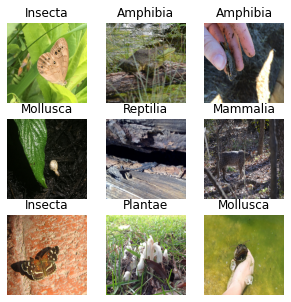

In [10]:
#first 9 images in training dataset
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

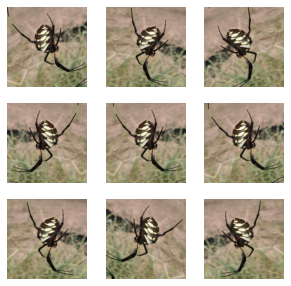

In [12]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
ag_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

ag_train_ds = ag_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
test_dir='/content/inaturalist_12K/val'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1,
    shuffle='False')

Found 2000 files belonging to 10 classes.


In [56]:
def best_model():
  num_classes = 10
  filter_no = [64,128,256,256,512]
  kernel_size = [4,3,3,2,2]
  act_function = ['relu','relu','relu','relu','relu']
  dense_act='relu'
  dense_neurons = 1024
  epoch=10
  lr=0.001
  optimizer =tf.keras.optimizers.SGD(lr=lr)
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, mode='max')
  model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(filter_no[0], kernel_size[0], activation=act_function[0]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[1], kernel_size[1], activation=act_function[1]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[2], kernel_size[2], activation=act_function[2]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[3], kernel_size[3], activation=act_function[3]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(filter_no[4], kernel_size[4], activation=act_function[4]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(dense_neurons, activation=dense_act,kernel_initializer='HeUniform'),
    layers.Dense(num_classes,activation='softmax')
  ])
  model.compile(optimizer=optimizer,loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  history = model.fit(ag_train_ds,validation_data=valid_ds,epochs=epoch)#,callbacks=[early_stopping])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  model.evaluate(test_ds,batch_size=1)
  return model

In [61]:
def predict(model):
  plt.figure(figsize=(25, 25))
  id=0
  for subdir in os.listdir(test_dir):
    files=[random.choice(os.listdir(os.path.join(test_dir, subdir))) for i in range(3)]
    index=1
    for file in files:
      path=os.path.join(os.path.join(test_dir, subdir),file)
      #print(path)
      img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) # Create a batch

      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])

      plt.subplot(10,10,id*10+index)
      plt.imshow(img)
      plt.title("{},{:.2f}".format(class_names[np.argmax(score)], 100 * np.max(score)))
      plt.axis("off")
      index+=1
    id+=1
  return

Epoch 1/10
282/282 [==============================] - 29s 95ms/step - loss: 2.9226 - accuracy: 0.1689 - val_loss: 2.5926 - val_accuracy: 0.1401
Epoch 2/10
282/282 [==============================] - 26s 91ms/step - loss: 2.3076 - accuracy: 0.2553 - val_loss: 2.2229 - val_accuracy: 0.2462
Epoch 3/10
282/282 [==============================] - 26s 91ms/step - loss: 2.0496 - accuracy: 0.3065 - val_loss: 2.1950 - val_accuracy: 0.2863
Epoch 4/10
282/282 [==============================] - 26s 91ms/step - loss: 1.8690 - accuracy: 0.3539 - val_loss: 2.0654 - val_accuracy: 0.3043
Epoch 5/10
282/282 [==============================] - 26s 92ms/step - loss: 1.7096 - accuracy: 0.4007 - val_loss: 2.1410 - val_accuracy: 0.3003
Epoch 6/10
282/282 [==============================] - 26s 91ms/step - loss: 1.5805 - accuracy: 0.4430 - val_loss: 2.0688 - val_accuracy: 0.3003
Epoch 7/10
282/282 [==============================] - 26s 91ms/step - loss: 1.4653 - accuracy: 0.4945 - val_loss: 2.0462 - val_accuracy:

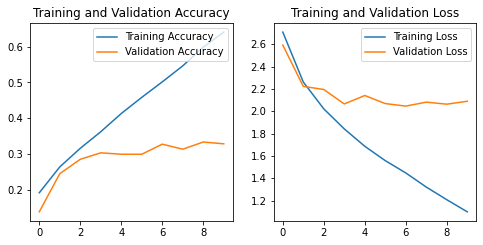

2000/2000 [==============================] - 20s 10ms/step - loss: 2.0421 - accuracy: 0.3495


In [58]:
model = best_model()

In [62]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 177, 177, 64)      3136      
_________________________________________________________________
batch_normalization_55 (Batc (None, 177, 177, 64)      256       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 86, 86, 128)       73856     
_________________________________________________________________
batch_normalization_56 (Batc (None, 86, 86, 128)       512       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 43, 43, 128)     

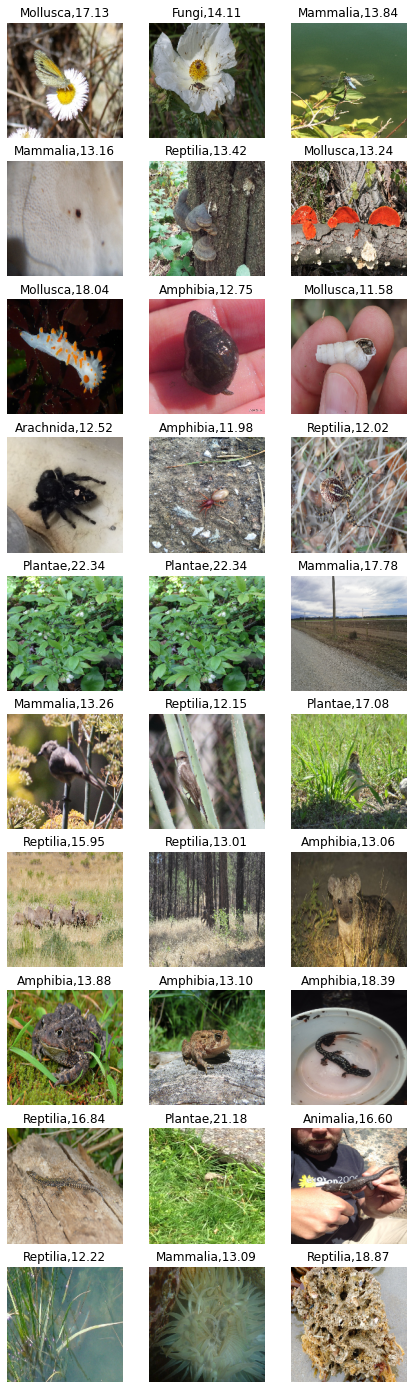

In [63]:
predict(model)

In [64]:
#Convolutional layers of model
lastlayer='conv2d'
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()
  lastlayer=layer.name
  print(layer.name, filters.shape)

conv2d_55 (4, 4, 3, 64)
conv2d_56 (3, 3, 64, 128)
conv2d_57 (3, 3, 128, 256)
conv2d_58 (2, 2, 256, 256)
conv2d_59 (2, 2, 256, 512)


**Random image selected for visualisation of filters**

In [84]:
while True:
  rn_class = random.choice(os.listdir(data_dir))
  if rn_class!='.DS_Store':
    break
rn_file = random.choice(os.listdir(os.path.join(data_dir, rn_class)))
rn_path = os.path.join(os.path.join(data_dir, rn_class),rn_file)
print(rn_path)

/content/inaturalist_12K/train/Fungi/27788cdf9e0a3bda0d6ddcdf186bf24b.jpg


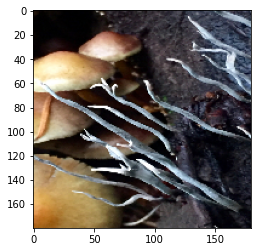

In [85]:
rn_image = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
plt.imshow(rn_image)

In [86]:
filters,biases=model.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filter_count=filters.shape[3]
if filter_count<8:
  no_of_filter=filter_count
else:
  no_of_filter=8
depth=filters.shape[2]
print(filters.shape)
print(filter_count,depth)

(4, 4, 3, 64)
64 3


**First few layer 1 convolutional filters (RGB channels along column)**

In [87]:
lg=int(math.log(filter_count,2))
row =int(math.pow(2,int(lg/2)))
col =int(math.pow(2,lg-int(lg/2)))

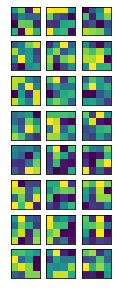

In [88]:
ind=0
plt.figure(figsize=(5, 5))
if no_of_filter>3:
  dim=no_of_filter
else:
  dim=3
for id in range(no_of_filter):
  filt=filters[:,:,:,id]
  for i in range(depth):
    ax=plt.subplot(dim,dim,id*dim+i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filt[:,:,i])
  ind+=1
plt.show()

In [89]:
img = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
visual_model=Model(inputs=model.input,outputs=model.layers[1].output)
visual_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11_input (InputLay [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 177, 177, 64)      3136      
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
_________________________________________________________________


**Visualiation of all filters in the first layer of Model**

In [90]:
feature_map=visual_model.predict(img_array)
print(feature_map.shape)

(1, 177, 177, 64)


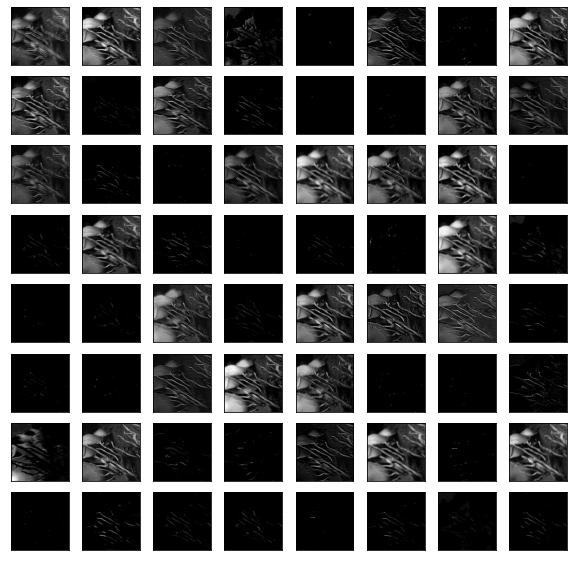

In [94]:
index=1
plt.figure(figsize=(10, 10))
for i in range(row):
  for j in range(col):
    ax=plt.subplot(col,col,i*col+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0,:,:,index-1],cmap='gray')
    index+=1
plt.show()

**Visualisation of Guided Back Propogation on 10 neurons in the last Convolutional Layer**

In [121]:
IMAGE_PATH = '/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
LAYER_NAME = lastlayer

In [122]:
IMG = keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(img_height, img_width))
IMG_array = keras.preprocessing.image.img_to_array(IMG)
IMG_array = tf.expand_dims(IMG_array, 0)

In [123]:
gb_model = tf.keras.models.Model(inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output])
oshape = model.get_layer(LAYER_NAME).output.shape[1:]
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [124]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [125]:
def guided_gb_plot(preprocessed_input,xindex,yindex,zindex):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0][xindex][yindex][zindex]
  grads = tape.gradient(outputs,inputs)[0]
  guided_back_prop =grads
  gb_viz = np.dstack((
              guided_back_prop[:, :, 0],
              guided_back_prop[:, :, 1],
              guided_back_prop[:, :, 2],
          ))       
  gb_viz -= np.min(gb_viz)
  gb_viz /= gb_viz.max()
  return gb_viz

In [126]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [127]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

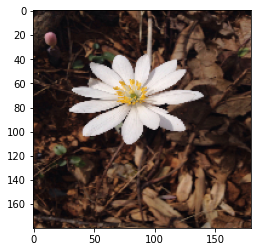

In [128]:
plt.imshow(IMG)

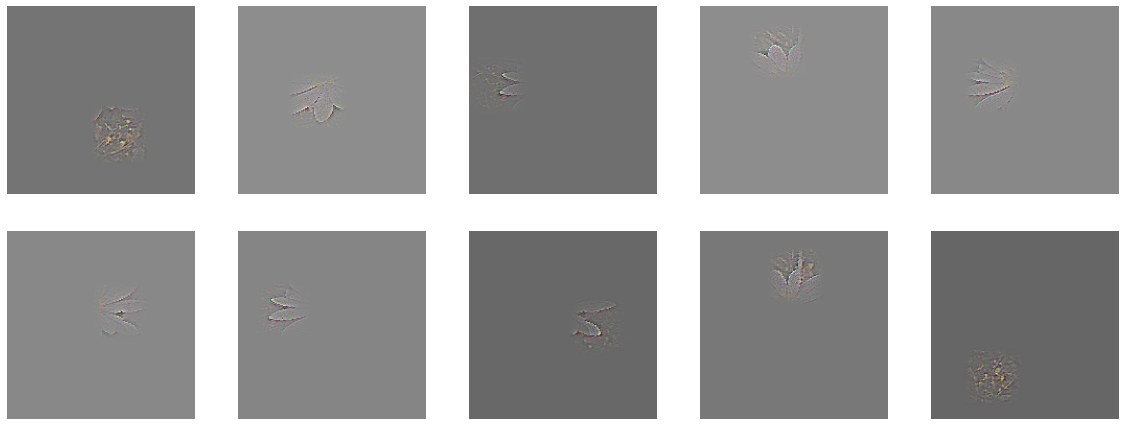

In [141]:
plt.figure(figsize=(20, 20))
ar=[(6,5,36),(4,3,305),(3,0,68),(1,3,481),(3,2,110),(3,5,27),(3,1,375),(4,6,384),(1,4,459),(7,2,144)]
for i in range(10):
  #xindex=random.randint(0,oshape[0]-1)
  #yindex=random.randint(0,oshape[1]-1)
  #zindex=random.randint(0,oshape[2]-1)
  (xindex,yindex,zindex)=ar[i]
  gb_v = guided_gb_plot(IMG_array,xindex,yindex,zindex)
  ax=plt.subplot(5,5,i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(gb_v)
  plt.axis("off")
plt.show()

**Visualisation of Grad-CAM**

In [142]:
import cv2
import tensorflow.keras.backend as K
from skimage.transform import resize
%matplotlib inline

In [143]:
def grad_CAM(preprocessed_input,img):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs,inputs)[0]
  weights = tf.reduce_mean(grads, axis=(0, 1))
  grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
  for i, w in enumerate(weights):
      grad_cam += w * outputs[:, :, i]
  grad_cam_img = cv2.resize(grad_cam.numpy(), (180, 180))
  grad_cam_img = np.maximum(grad_cam_img, 0)
  heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
  grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.8, grad_cam_img, 1, 0)
  return output_image

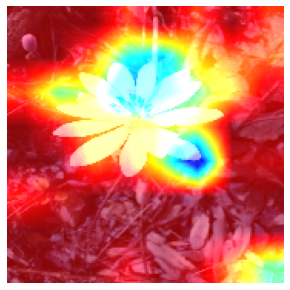

In [144]:
plt.figure(figsize=(60, 60))
file_path ='/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
ig = keras.preprocessing.image.load_img(file_path, target_size=(img_height, img_width))
ig_array = keras.preprocessing.image.img_to_array(ig)
preprocessed = tf.expand_dims(ig_array, 0)
out_cam = grad_CAM(preprocessed,ig_array)
ax=plt.subplot(10,10,i+1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out_cam)
plt.axis("off")
plt.show()

**Guided Grad CAM Visualisation**

In [145]:
def guided_grad_CAM(preprocessed_input):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs,inputs)[0]
  guided_back_prop=grads
  weights = tf.reduce_mean(grads, axis=(0, 1))
  grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
  for i, w in enumerate(weights):
      grad_cam += w * outputs[:, :, i]
  guided_cam = np.maximum(grad_cam, 0)
  guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
  guided_cam = resize(guided_cam, (180,180), preserve_range=True)
  gd_gb = np.dstack((
        guided_back_prop[:, :, 0] * guided_cam,
        guided_back_prop[:, :, 1] * guided_cam,
        guided_back_prop[:, :, 2] * guided_cam,
    ))
  return gd_gb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


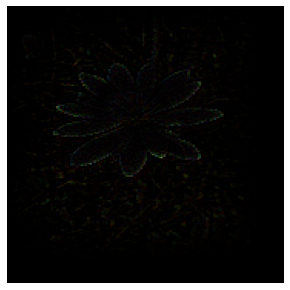

In [152]:
plt.figure(figsize=(60, 60))
file_path = '/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
ig = keras.preprocessing.image.load_img(file_path, target_size=(img_height, img_width))
ig_array = keras.preprocessing.image.img_to_array(ig)
preprocessed = tf.expand_dims(ig_array, 0)
out_cam = guided_grad_CAM(preprocessed)
ax=plt.subplot(10,10,i+1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out_cam)
plt.axis("off")
plt.show()